## COVID-19 Case Growth Rates are Declining

While the number of COVID-19 cases is increasing in most regions, the rate of increase is slowing, suggesting that eforts to control the spread of the virus are working. 


In [1]:
import sys
# Install required packages
#!{sys.executable} -mpip -q install matplotlib seaborn statsmodels pandas publicdata metapack

%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import metapack as mp
import rowgenerators as rg
import publicdata as pub
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import  linear_model
sns.set(color_codes=True)


#plt.style.use('./d4sci.mplstyle')


In [2]:
pkg = mp.open_package('http://library.metatab.org/jhu.edu-covid19-2.4.0.csv')

Perhaps the most popular image of the COVID-19 crisis is the semi-log cumulative cases chart from the Financial Times, which shows the growth of COVID-19 cases, by region, with a logarithmic Y axis. Recent version include lines for specific growth rates, and annotations for important events. 

<img src="https://www.ft.com/__origami/service/image/v2/images/raw/http%3A%2F%2Fcom.ft.imagepublish.upp-prod-us.s3.amazonaws.com%2F2c0da71c-6e12-11ea-89df-41bea055720b?fit=scale-down&quality=highest&source=next&width=800"/>


In [3]:
from statsmodels.nonparametric.smoothers_lowess import lowess

confirmed_df = pkg.resource('confirmed').dataframe()
confirmed_df['double_days'] = np.log(2)/ np.log(1+confirmed_df.rate_t5d)

t = confirmed_df.copy()
t = t[ ((t.country != 'US - aggregate') & (t.province.isnull())) | (t.location == 'China - aggregate') ]
t = t[['location','date','days_100']].dropna().groupby('location').days_100.max().sort_values(ascending=False)

countries_ordered = list(t.index)

confirmed_df['country_rank'] = np.nan

for idx, row in confirmed_df.iterrows():
    try:
        confirmed_df.at[idx,'country_rank'] = countries_ordered.index(row.location)
    except ValueError:
        pass

countries = countries_ordered[:20]

country_max_days = confirmed_df[confirmed_df.location.isin(countries)].days_100.max()
country_max_days

confirmed_df = confirmed_df.sort_values(['country_rank', 'date'])

confirmed_df['confirmed_diff'] = np.nan
confirmed_df['confirmed_norm'] = np.nan
confirmed_df['confirmed_smooth'] = np.nan

for idx, g in confirmed_df.groupby('location'):
    
    if g.days_100.max() and not np.isnan(g.days_100.max()):
        frac = 7.0/(g.days_100.max())

        if np.isnan(frac) or frac < .2 or frac > .5:
            frac = .2

        l = lowess( g.confirmed, g.days_100, frac=frac, it=2)
        if len(l[:,1]) == len(g.confirmed):
            confirmed_df.at[confirmed_df.location==idx,'confirmed_smooth']  = l[:,1]

for idx, g in confirmed_df.groupby('location'):
    confirmed_df.at[confirmed_df.location==idx,'confirmed_diff'] =  g.confirmed_smooth.diff()
    if not np.isnan(g.confirmed_smooth.max()):
        confirmed_df.at[confirmed_df.location==idx,'confirmed_norm'] =  g.confirmed_smooth/g.confirmed_smooth.max()

s =  confirmed_df.confirmed_smooth
confirmed_df['rate_7d'] = np.exp((np.log(s)-np.log(s.shift(7))) / 7)-1
        
cgt0 = confirmed_df[(confirmed_df.days_100 > 0) ].copy()


/Users/eric/opt/anaconda3/envs/metapack/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
/Users/eric/opt/anaconda3/envs/metapack/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in log


We will reproduce that chart, then show some other views to answer a particularly interesting question: when will each region have its first day of zero new cases?. Here is the re-produced chart, using a [processed version of the Johns Hopkins dataset](https://data.sandiegodata.org/dataset/jhu-edu-covid19/) from the [San Diego Regional Data Library](https://www.sandiegodata.org/). 

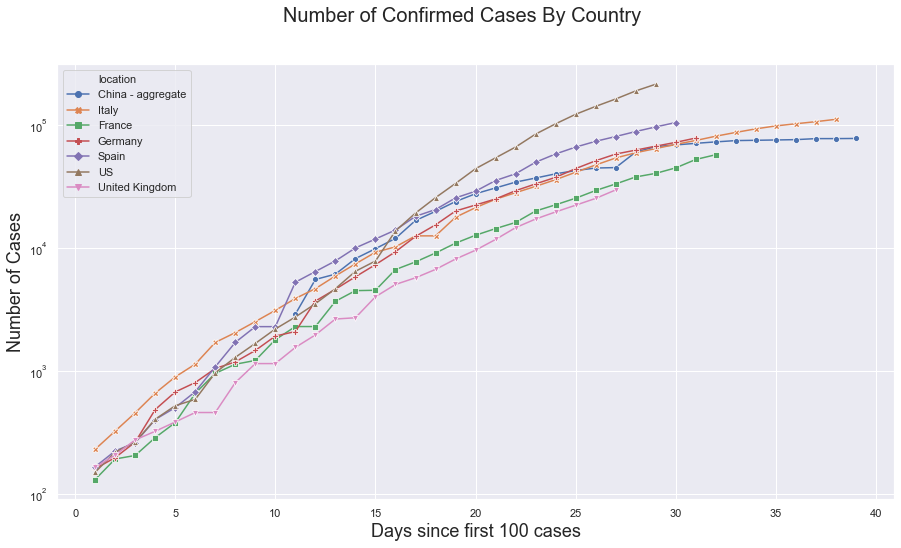

In [4]:

t = cgt0[(cgt0.days_100 < 40) ]
t = t[t.location.isin( ['Italy', 'Spain', 'US','Germany','France', 'United Kingdom','China - aggregate'])]

fig, ax = plt.subplots(figsize=(15,8))
fig.suptitle('Number of Confirmed Cases By Country', fontsize=20)

sns.lineplot(ax=ax, x='days_100',y='confirmed', data=t, hue='location', style='location', ci=None,dashes=False, markers=True)
ax.set_xlabel('Days since first 100 cases', fontsize=18)
ax.set_ylabel('Number of Cases', fontsize=18)
ax.set_yscale('log')

The Financial Times chart shows dashed black lines for the const rate of growth line, such as "CASES DOUBLE EVERY DAY" and "...EVERY THREE DAYS", but it is also evident that the growth curves for the countries are not straight; they bend down. This means that the growth rate is decreasing: if the number of cases today is 33% more than the number of cases yesterday, it may only be 31% more than today tomorrow. If that reduction continues, eventually the number of new cases per day will be zero, an event that signals we are near the end of the worst of the pandemic. 

In [5]:
# Get the list of US state locations that have 5 or more records
t = confirmed_df[(confirmed_df.days_100<30) & (confirmed_df.days_100>=0)] 
t = t[(t.country == 'US') ]
  
tt = t.groupby('location').size()
us_states = list(tt[tt>=5].index)
us_max_days = tt.max()


A scatter plot of the growth rates of a selection of the US states in the Johns Hopkins dataset shows that in most states, the growth rate is declining over time, and the average predicted date for US states ( excluding New York) to reach a zero growth rate is 20 days past the date that the region hit 100 cases. 

In [6]:
def plot_exp_fit(t, ax):

    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit

    def func(x, a, b, c): # Basic Exponential
        return a * np.exp(-b * x) + c

    t = t.replace(np.inf, np.nan).dropna(subset=['rate_t5d']).sort_values('days_100')

    popt, pcov = curve_fit(func, t.days_100, t.rate_t5d)

    ax.plot(t.days_100, func(t.days_100, *popt), 'r-')
    
def plot_growth_reg_100(t, y_col, ax = None, subtitle='', fit=False, exp=True):
    
    t = t.replace(np.inf, np.nan).dropna(subset=['rate_t5d']).sort_values('days_100')
    
    if not ax:
        fig, ax = plt.subplots(figsize=(12,8))
        fig.suptitle('Growth Rate in Confirmed Cases, Trailing 5 days' +("\n"+subtitle if subtitle else ''),
                 fontsize=20)

    sns.scatterplot(ax=ax, x='days_100',y=y_col, data=t)
    
   
    ax.set_xlabel('Days Since 100 Cases', fontsize=18)
    ax.set_ylabel('Rate of Growth', fontsize=18)

    plt.gcf().text(.45,0, f"Source data : JHU CSSE, updated {pkg['Root'].find_first('root.modified').value} ", fontsize=14) 
    
    if fit:
        x = t.days_100.values.reshape(len(t), 1)
        y = t[y_col].values.reshape(len(t), 1)

        regr = linear_model.LinearRegression()
        regr.fit(x, y)
    
        ax.plot(x, regr.predict(x), color='blue', linewidth=3)
    
        print('Coefficients:', regr.coef_, regr.intercept_)
        print("Correlation:", t.days_100.corr(t.rate_t5d))

        m = regr.coef_[0][0]
        b = regr.intercept_[0]

        print(f"Zero growth at {-b/m} days")
    
    if exp:
         plot_exp_fit(t, ax)
    
    return fig, ax



def pgr(df, region):
    """Convenience function for plot_growth_reg_100"""
    t = df[df.location == region ]
    
    return plot_growth_reg_100(t, 'rate_t5d', ax = None, subtitle=region)

def cgrid(df, max_days):
    """Small mutiples of charts like plot_growth_reg_100"""
    

    g = sns.FacetGrid(df,  col="location", col_wrap=4, margin_titles=True, xlim=(-1,max_days+1))
    
    m = g.map(sns.lineplot, "days_100", "confirmed_norm", color="#334488");
    m.set_axis_labels("Days past 100 Cases", "Growth Rate");
    plt.gcf().text(.58,-0.03, f"Source data : JHU CSSE, updated {pkg['Root'].find_first('root.modified').value} ", fontsize=14) 

    return g


def fgrid(df, max_days):
    """Small mutiples of charts like plot_growth_reg_100"""
    g = sns.FacetGrid(df,  col="location", col_wrap=4, margin_titles=True, ylim=(0,.8), xlim=(-1,max_days+1))
    
    t = df.copy()
    
    m = g.map(sns.lineplot, "days_100", "rate_7d", color="#334488");
    m.set_axis_labels("Days past 100 Cases", "Growth Rate");
    plt.gcf().text(.58,-0.03, f"Source data : JHU CSSE, updated {pkg['Root'].find_first('root.modified').value} ", fontsize=14) 

    return g

def diff_fgrid(df, max_days):
    """Small mutiples of charts like plot_growth_reg_100"""
    g = sns.FacetGrid(df,  col="location", col_wrap=4, margin_titles=True, xlim=(-1,country_max_days) ) 
    
    m = g.map(sns.lineplot, "days_100", "confirmed_diff", color="#334488");
   
    plt.gcf().text(.58,-0.03, f"Source data : JHU CSSE, updated {pkg['Root'].find_first('root.modified').value} ", fontsize=14) 

    return g

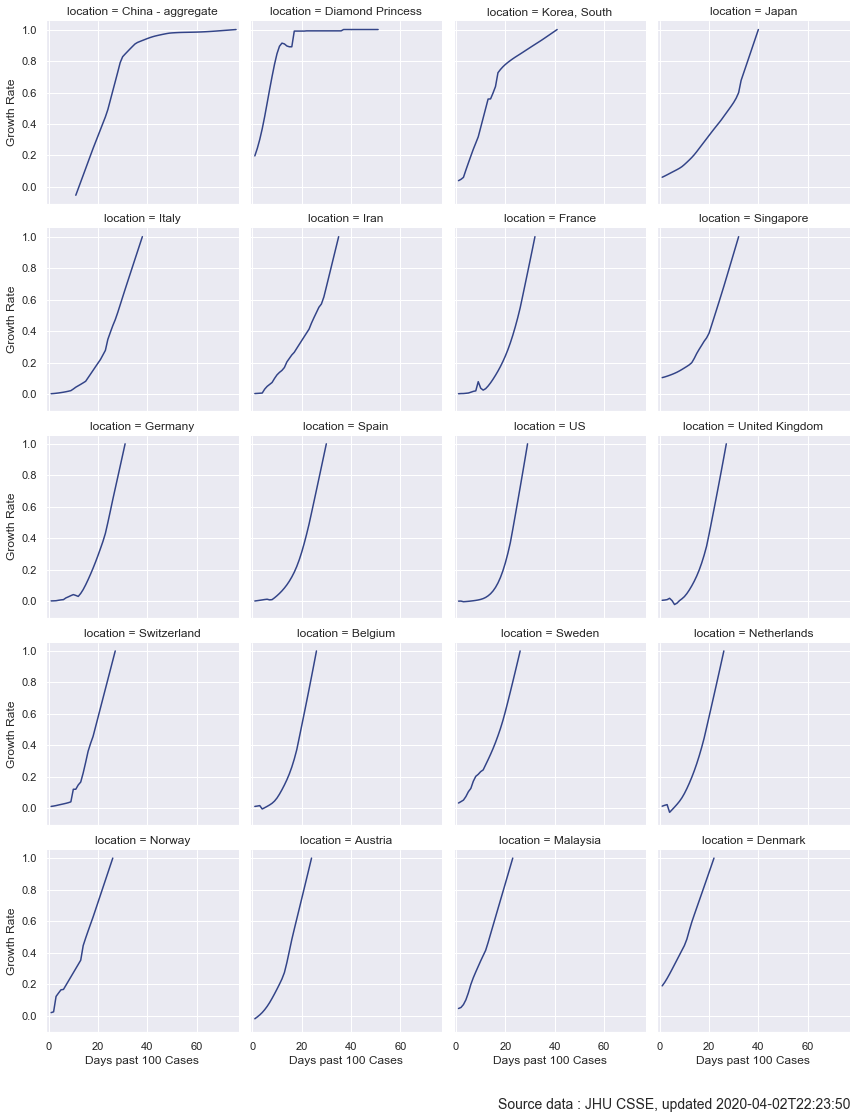

In [7]:
t = cgt0[cgt0.location.isin(countries)].copy()

for idx, g in t.groupby('location'):
    t.at[t.location==idx,'confirmed_diff'] = g.confirmed_diff / g.confirmed_diff.max()

    
r = cgrid(t, country_max_days)

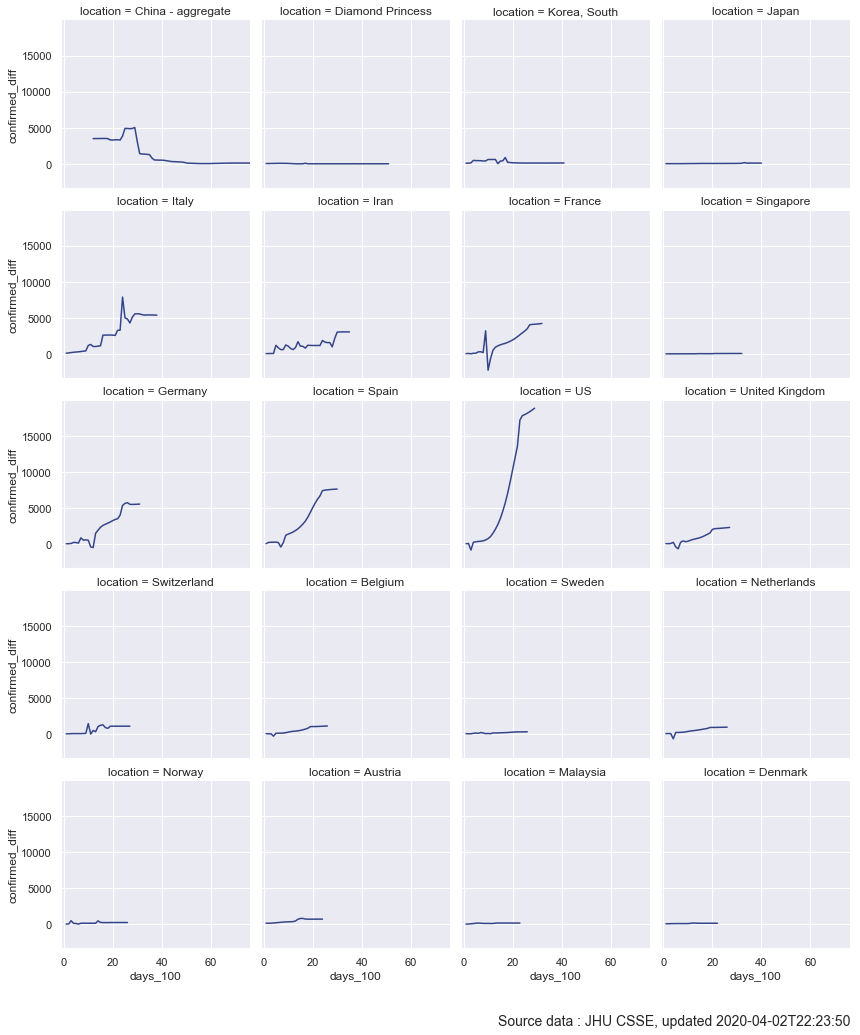

In [8]:
t = cgt0[cgt0.location.isin(countries)].copy()

r = diff_fgrid(t, country_max_days)
plt.subplots_adjust(top=0.9)
r.fig.suptitle("", fontsize=20);

There are some exceptions to this prediction, as the use of the term "selection of states" would indicate: the growth rate for New York is headed in the wrong direction. 

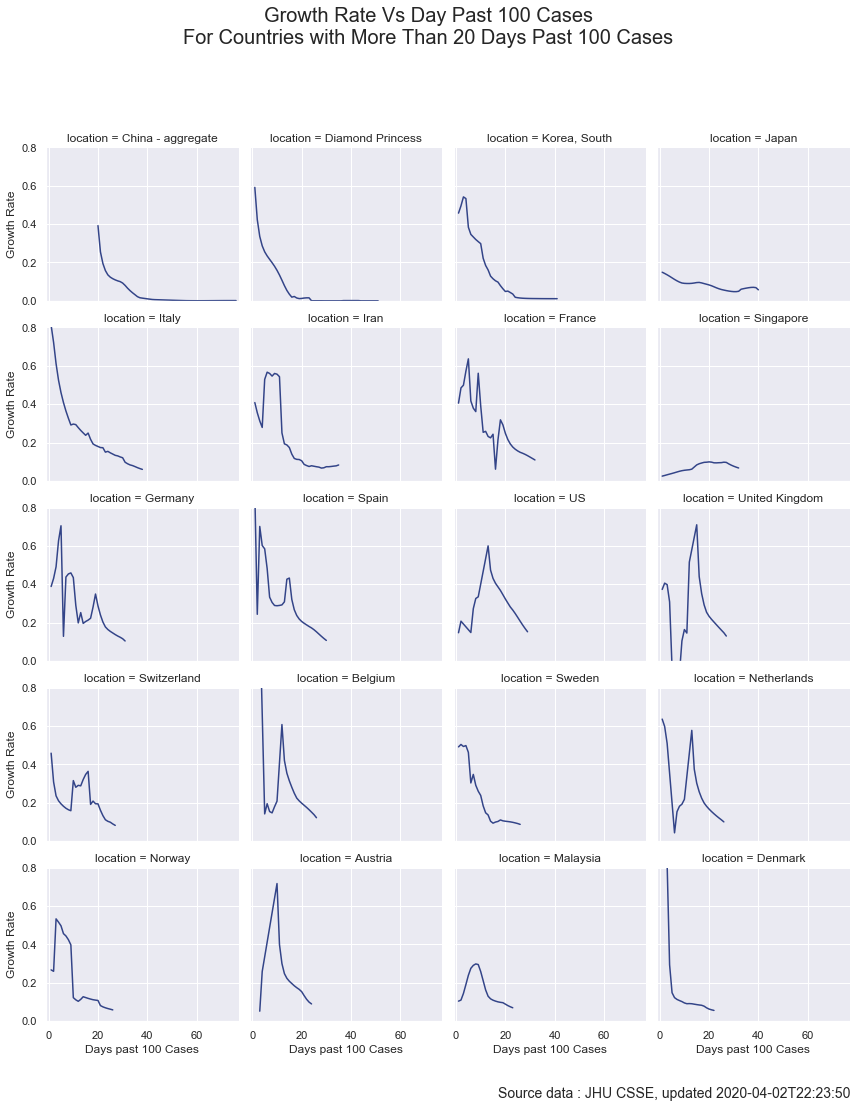

In [9]:
#c = bump_countries 
c = countries

t = cgt0[cgt0.location.isin(c)]

r = fgrid(t, country_max_days)
plt.subplots_adjust(top=.85)
r.fig.suptitle("Growth Rate Vs Day Past 100 Cases\nFor Countries with More Than 20 Days Past 100 Cases", fontsize=20);

New York's growth rate will eventually turn around, but it is likely that the state will hit zero cases per day much later than other US states. 

Italy's growth rate is also declining, but since Italy was hit earlier, and harder, the predicted Zero Day is day 46, April 8


In [10]:
t = cgt0[cgt0.location.isin(countries)]
t = t.replace(np.inf, np.nan).dropna(subset=['rate_t5d'])
x = t.days_100.values.reshape(len(t), 1)
y = t["rate_t5d"].values.reshape(len(t), 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)
ax.plot(x, regr.predict(x), linewidth=1)

print('Coefficients:', regr.coef_, regr.intercept_)
print("Correlation:", t.days_100.corr(t.rate_t5d))

m = regr.coef_[0][0]
b = regr.intercept_[0]

print(f"Zero growth at {-b/m} days")
  

Coefficients: [[-0.00769698]] [0.34073495]
Correlation: -0.6087033295711985
Zero growth at 44.268660885168195 days


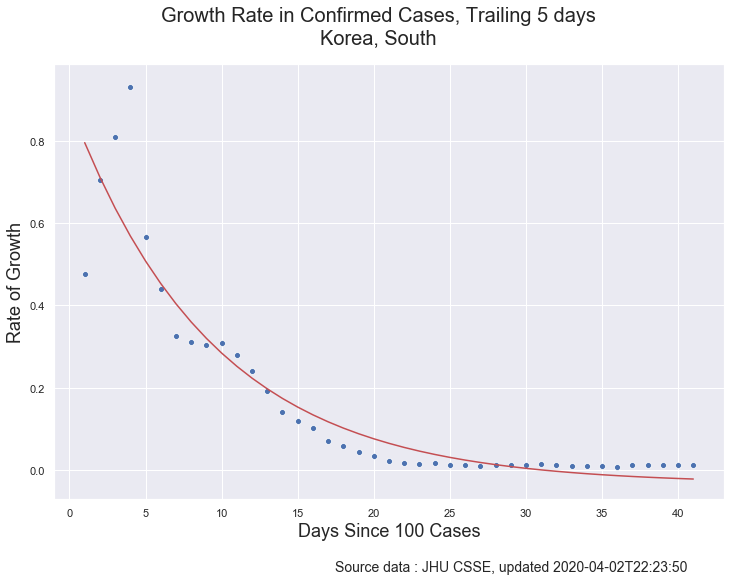

In [11]:
t = cgt0[cgt0.location == 'Korea, South' ]
fig, ax = plot_growth_reg_100(t,'rate_t5d', subtitle='Korea, South', fit=False);
#plot_exp_fit(t, ax)

/Users/eric/opt/anaconda3/envs/metapack/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/eric/opt/anaconda3/envs/metapack/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/eric/opt/anaconda3/envs/metapack/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


country                     object
province                    object
location                    object
date                datetime64[ns]
confirmed                    int64
date_10             datetime64[ns]
days_10                    float64
date_100            datetime64[ns]
days_100                   float64
rate_t5d                   float64
confirmed_log              float64
double_days                float64
country_rank               float64
confirmed_diff             float64
confirmed_norm             float64
confirmed_smooth           float64
rate_7d                    float64
dtype: object


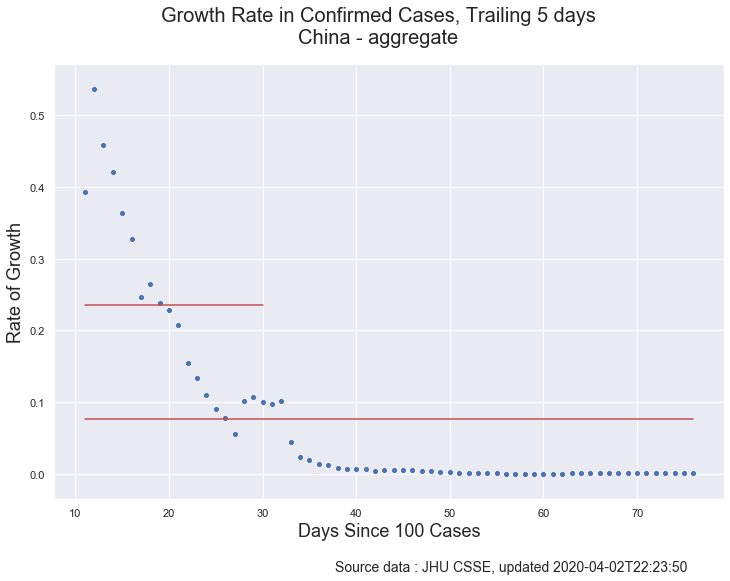

In [12]:
t = cgt0[cgt0.location == 'China - aggregate'].copy()
t = t.replace(np.inf, np.nan).dropna(subset=['rate_t5d']).sort_values('days_100')
fig, ax = plot_growth_reg_100(t,'rate_t5d', subtitle='China - aggregate');

def plot_exp_fit(t, ax):

    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit

    def func(x, a, b, c): # Basic Exponential
        return a * np.exp(-b * x) + c

    t = t.replace(np.inf, np.nan).dropna(subset=['rate_t5d']).sort_values('days_100')
    print(t.dtypes)
    popt, pcov = curve_fit(func, t.days_100, t.rate_t5d)
    

    ax.plot(t.days_100, func(t.days_100, *popt), 'r-')

r = t.rate_t5d
t['rate_t5d'] = r.where(r > .1, .1)
t = t.iloc[0:20]         
plot_exp_fit(t, ax)

In [13]:
t

,country,province,location,date,confirmed,date_10,days_10,date_100,days_100,rate_t5d,confirmed_log,double_days,country_rank,confirmed_diff,confirmed_norm,confirmed_smooth,rate_7d
17028,China,aggregate,China - aggregate,2020-01-27,2877,2020-01-22,11.0,2020-01-22,11.0,0.393259,7.964851,2.090024,0.0,NaN,-0.052680,-4339.995057,NaN
17029,China,aggregate,China - aggregate,2020-01-28,5509,2020-01-22,12.0,2020-01-22,12.0,0.536641,8.614320,1.613476,0.0,3487.016365,-0.010354,-852.978692,NaN
17030,China,aggregate,China - aggregate,2020-01-29,6087,2020-01-22,13.0,2020-01-22,13.0,0.459228,8.714075,1.834172,0.0,3490.411889,0.032014,2637.433197,NaN
17031,China,aggregate,China - aggregate,2020-01-30,8141,2020-01-22,14.0,2020-01-22,14.0,0.420818,9.004791,1.973469,0.0,3494.776057,0.074435,6132.209253,NaN
17032,China,aggregate,China - aggregate,2020-01-31,9802,2020-01-22,15.0,2020-01-22,15.0,0.364141,9.190444,2.232178,0.0,3500.288970,0.116922,9632.498223,NaN
17033,China,aggregate,China - aggregate,2020-02-01,11891,2020-01-22,16.0,2020-01-22,16.0,0.328176,9.383621,2.442321,0.0,3506.258563,0.159482,13138.756786,NaN
17044,China,aggregate,China - aggregate,2020-02-02,16630,2020-01-22,17.0,2020-01-22,17.0,0.247280,9.719024,3.136909,0.0,3510.322633,0.202092,16649.079419,NaN
17055,China,aggregate,China - aggregate,2020-02-03,19716,2020-01-22,18.0,2020-01-22,18.0,0.264978,9.889236,2.948872,0.0,3478.159663,0.244311,20127.239082,NaN
17056,China,aggregate,China - aggregate,2020-02-04,23707,2020-01-22,19.0,2020-01-22,19.0,0.238340,10.073568,3.242468,0.0,3298.432718,0.284348,23425.671800,NaN
17057,China,aggregate,China - aggregate,2020-02-05,27440,2020-01-22,20.0,2020-01-22,20.0,0.228610,10.219794,3.366703,0.0,3291.518035,0.324302,26717.189835,0.392062


country                     object
province                   float64
location                    object
date                datetime64[ns]
confirmed                    int64
date_10             datetime64[ns]
days_10                    float64
date_100            datetime64[ns]
days_100                   float64
rate_t5d                   float64
confirmed_log              float64
double_days                float64
country_rank               float64
confirmed_diff             float64
confirmed_norm             float64
confirmed_smooth           float64
rate_7d                    float64
dtype: object


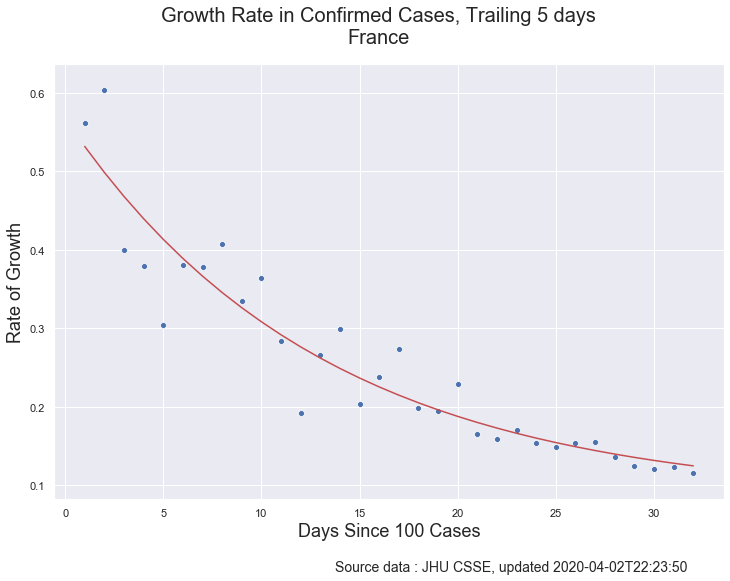

In [14]:

t = cgt0[cgt0.location == 'France' ]
fig, ax = plot_growth_reg_100(t,'rate_t5d', subtitle='France');


country                     object
province                    object
location                    object
date                datetime64[ns]
confirmed                    int64
date_10             datetime64[ns]
days_10                    float64
date_100            datetime64[ns]
days_100                   float64
rate_t5d                   float64
confirmed_log              float64
double_days                float64
country_rank               float64
confirmed_diff             float64
confirmed_norm             float64
confirmed_smooth           float64
rate_7d                    float64
dtype: object


/Users/eric/opt/anaconda3/envs/metapack/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


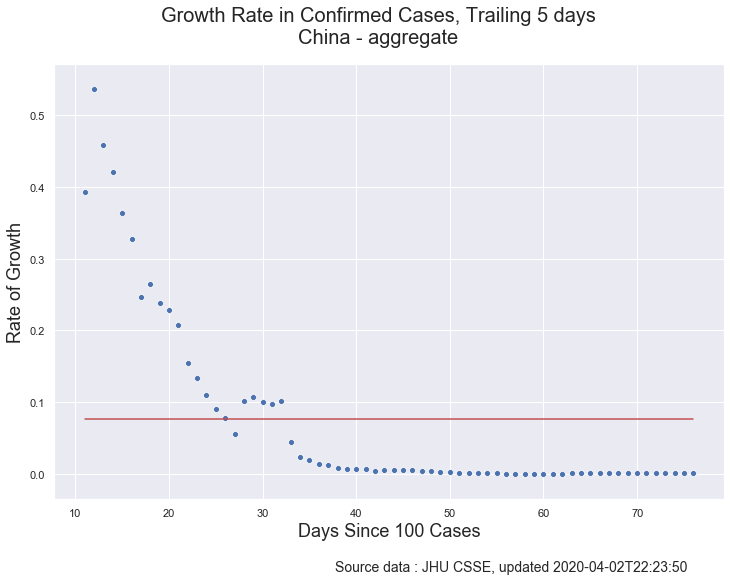

In [15]:
t = cgt0[cgt0.location == 'China - aggregate' ]
plot_growth_reg_100(t,'rate_t5d', subtitle='China - aggregate');

In [16]:
t[t.country.isin( ['US'])]

,country,province,location,date,confirmed,date_10,days_10,date_100,days_100,rate_t5d,confirmed_log,double_days,country_rank,confirmed_diff,confirmed_norm,confirmed_smooth,rate_7d


country                     object
province                   float64
location                    object
date                datetime64[ns]
confirmed                    int64
date_10             datetime64[ns]
days_10                    float64
date_100            datetime64[ns]
days_100                   float64
rate_t5d                   float64
confirmed_log              float64
double_days                float64
country_rank               float64
confirmed_diff             float64
confirmed_norm             float64
confirmed_smooth           float64
rate_7d                    float64
dtype: object


/Users/eric/opt/anaconda3/envs/metapack/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


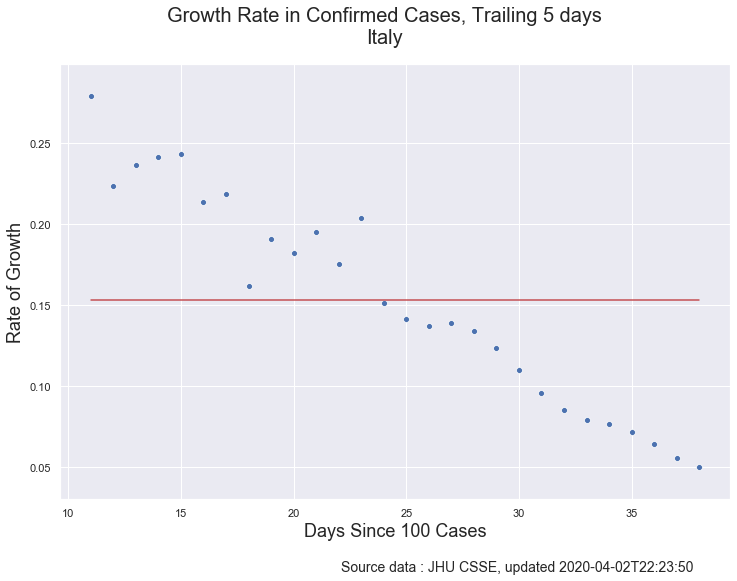

In [17]:
t = cgt0[cgt0.days_100>10] 
t = t[t.location.isin( ['Italy'])]

plot_growth_reg_100(t,'rate_t5d', subtitle='Italy');


California, however, responded to the pandemic quickly and vigorously, so the growth rate is declining more quickly, with a predicted Zero Day of day 28, April 7. 

The declining growth rates are very good news, and indication that efforts to reduce the spread of the virus are working. The first Zero Days in each region will not mark the end of restrictions on movement, but they are an indication that a return to normalcy is not far away.  

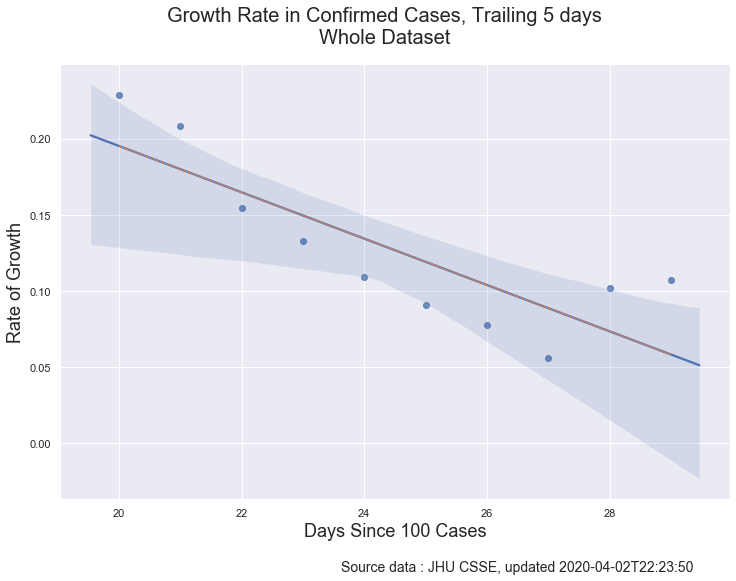

Coefficients: [[-0.01520897]] [0.49932467]
Correlation: -0.8280414281341324
Zero growth at 32.83092659619348 days


In [18]:
def plot_growth_reg_multi_100(t, y_col, ax = None, subtitle=''):
    
    if not ax:
        fig, ax = plt.subplots(figsize=(12,8))
        fig.suptitle('Growth Rate in Confirmed Cases, Trailing 5 days' +("\n"+subtitle if subtitle else ''),
                 fontsize=20)

    sns.regplot(ax=ax, x='days_100',y=y_col, data=t)

    for idx, g in t.groupby('location'):
    
        x = g.days_100.values.reshape(len(g), 1)
        y = g[y_col].values.reshape(len(g), 1)

        regr = linear_model.LinearRegression()
        regr.fit(x, y)
        ax.plot(x, regr.predict(x), linewidth=1)
    

    ax.set_xlabel('Days Since 100 Cases', fontsize=18)
    ax.set_ylabel('Rate of Growth', fontsize=18)

    plt.gcf().text(.45,0, f"Source data : JHU CSSE, updated {pkg['Root'].find_first('root.modified').value} ", fontsize=14) 
    plt.show()

    
    x = t.days_100.values.reshape(len(t), 1)
    y = t[y_col].values.reshape(len(t), 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    ax.plot(x, regr.predict(x), linewidth=1)
    
    print('Coefficients:', regr.coef_, regr.intercept_)
    print("Correlation:", t.days_100.corr(t.rate_t5d))

    m = regr.coef_[0][0]
    b = regr.intercept_[0]
  
    print(f"Zero growth at {-b/m} days")
    
    return fig, ax

t = confirmed_df[(confirmed_df.days_100<30) & (confirmed_df.days_100>=7)].replace(np.inf, np.nan). dropna()


plot_growth_reg_multi_100(t, 'rate_t5d', subtitle='Whole Dataset');

In [19]:
t = confirmed_df[(confirmed_df.days_100<30) & (confirmed_df.days_100>=7)].replace(np.inf, np.nan). dropna()

def gen_data(df):

    for idx, g in df.groupby('location'):

        x = g.days_100.values.reshape(len(g), 1)
        y = g.rate_t5d.values.reshape(len(g), 1)

        regr = linear_model.LinearRegression()
        regr.fit(x, y)
        
        m = regr.coef_[0][0]
        b = regr.intercept_[0]
        
        yield idx, m, b, g.days_100.corr(g.rate_t5d) if m !=0 else np.nan, -b/m if m !=0 else np.nan
        
        
zeros = pd.DataFrame(list(gen_data(t)), columns = "location m b corr zero_day".split())
   
zeros.head()
        

,location,m,b,corr,zero_day
0,China - aggregate,-0.015209,0.499325,-0.828041,32.830927


In [20]:
zeros.m.describe()

count    1.000000
mean    -0.015209
std           NaN
min     -0.015209
25%     -0.015209
50%     -0.015209
75%     -0.015209
max     -0.015209
Name: m, dtype: float64

In [21]:
zeros[zeros.zero_day < 0]

,location,m,b,corr,zero_day


In [22]:
zeros['corr'].describe()

count    1.000000
mean    -0.828041
std           NaN
min     -0.828041
25%     -0.828041
50%     -0.828041
75%     -0.828041
max     -0.828041
Name: corr, dtype: float64

In [23]:
zeros.dropna().sort_values('corr').tail()

,location,m,b,corr,zero_day
0,China - aggregate,-0.015209,0.499325,-0.828041,32.830927


In [24]:
death_df = pkg.resource('deaths').dataframe()
dgt0 = death_df[(death_df.days_10 > 0) ]

In [25]:
def plot_growth_reg_10(t, y_col, ax = None, subtitle='', what='deaths', fit=True, exp=False):
    
    t = t.replace(np.inf, np.nan).dropna(subset=['rate_t5d']).sort_values('days_10')
    
    if not ax:
        fig, ax = plt.subplots(figsize=(12,8))
        fig.suptitle(f'Growth Rate in {what.title()}, Trailing 5 days' +("\n"+subtitle if subtitle else ''),
                 fontsize=20)

    sns.regplot(ax=ax, x='days_10',y=y_col, data=t)
    
   
    ax.set_xlabel('Days Since 10 Cases', fontsize=18)
    ax.set_ylabel('Rate of Growth', fontsize=18)

    plt.gcf().text(.45,0, f"Source data : JHU CSSE, updated {pkg['Root'].find_first('root.modified').value} ", fontsize=14) 
    
    if fit:
        x = t.days_10.values.reshape(len(t), 1)
        y = t[y_col].values.reshape(len(t), 1)

        regr = linear_model.LinearRegression()
        regr.fit(x, y)
    
        ax.plot(x, regr.predict(x), color='blue', linewidth=3)
    
        print('Coefficients:', regr.coef_, regr.intercept_)
        print("Correlation:", t.days_10.corr(t.rate_t5d))

        m = regr.coef_[0][0]
        b = regr.intercept_[0]

        print(f"Zero growth at {-b/m} days")
    
    if exp:
         plot_exp_fit(t, ax)
    
    return fig, ax

Coefficients: [[-0.01204416]] [0.48362846]
Correlation: -0.9313310217194718
Zero growth at 40.154602881611225 days


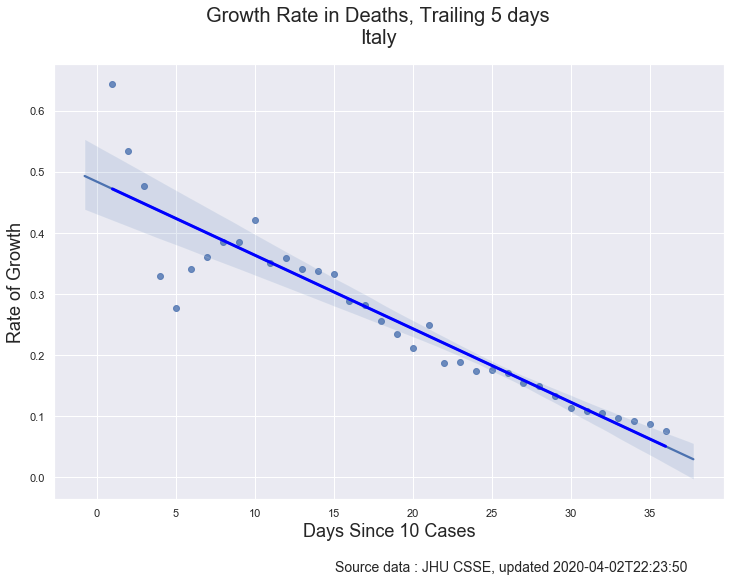

In [26]:
t = dgt0[dgt0.days_10 > 0] 
t = t[t.location.isin( ['Italy'])]
plot_growth_reg_10(t,'rate_t5d', subtitle='Italy');

In [27]:
t = dgt0[dgt0.days_10 > 0] 
t.location.unique()

array(['Albania', 'Algeria', 'Andorra', 'Argentina', 'Austria', 'Belgium',
       'Bosnia and Herzegovina', 'Brazil', 'Burkina Faso',
       'Canada - British Columbia', 'Canada - Ontario', 'Canada - Quebec',
       'Chile', 'China - Heilongjiang', 'China - Henan', 'China - Hubei',
       'Colombia', 'Diamond Princess', 'Czechia', 'Denmark',
       'Dominican Republic', 'Ecuador', 'Egypt', 'Finland', 'France',
       'Germany', 'Greece', 'Hungary', 'India', 'Indonesia', 'Iran',
       'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan', 'Korea, South',
       'Lebanon', 'Luxembourg', 'Malaysia', 'Mexico', 'Morocco',
       'Netherlands', 'Norway', 'Pakistan', 'Panama', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia',
       'San Marino', 'Saudi Arabia', 'Serbia', 'Slovenia', 'Spain',
       'Sweden', 'Switzerland', 'Thailand', 'Tunisia', 'Turkey',
       'Ukraine', 'United Kingdom', 'US', 'Australia - aggregate',
       'Canada - aggregate', 'China - aggregate'], dtyp

In [28]:
t = cgt0[cgt0.days_100 > 0] 
t = t[t.location.isin( ['Italy'])].sort_values('date')
t.head().T

,9063,9064,9065,9066,9067
country,Italy,Italy,Italy,Italy,Italy
province,NaN,NaN,NaN,NaN,NaN
location,Italy,Italy,Italy,Italy,Italy
date,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00
confirmed,229,322,453,655,888
date_10,2020-02-21 00:00:00,2020-02-21 00:00:00,2020-02-21 00:00:00,2020-02-21 00:00:00,2020-02-21 00:00:00
days_10,3,4,5,6,7
date_100,2020-02-23 00:00:00,2020-02-23 00:00:00,2020-02-23 00:00:00,2020-02-23 00:00:00,2020-02-23 00:00:00
days_100,1,2,3,4,5
rate_t5d,1.37981,1.54769,0.866438,0.602396,0.417804


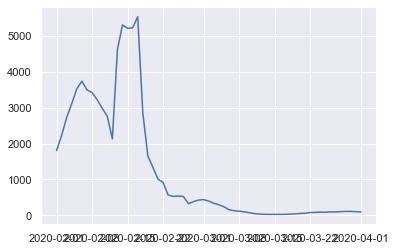

In [29]:
t = cgt0[cgt0.days_100 > 0] 
t = t[t.location.isin( ['China - aggregate'])].sort_values('date')
t.head().T
t['diff'] = t.confirmed.rolling(5).mean().diff().dropna()
plt.plot(t.date, t['diff'])

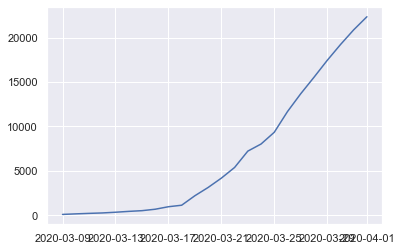

In [30]:
t = cgt0[cgt0.days_100 > 0] 
t = t[t.location.isin( ['US'])].sort_values('date')
t.head().T
t['diff'] = t.confirmed.rolling(5).mean().diff().dropna()
plt.plot(t.date, t['diff'])

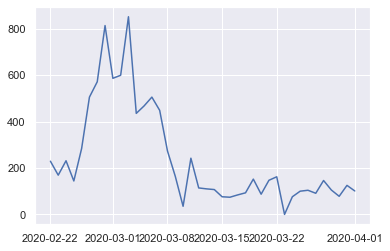

In [31]:
t = cgt0[cgt0.days_100 > 0] 
t = t[t.location.isin( ['Korea, South'])].sort_values('date')
t.head().T
t['diff'] = t.confirmed.diff().dropna()
plt.plot(t.date, t['diff'])

In [32]:
country_max_days

76.0

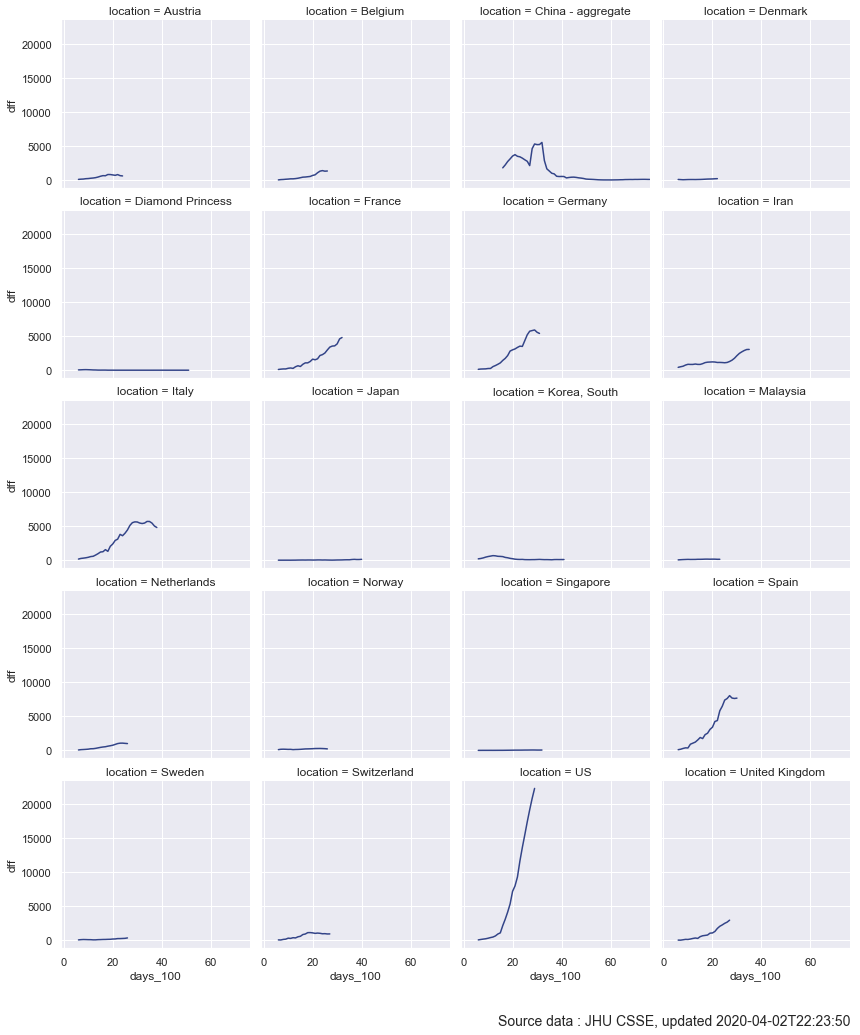

In [33]:
def diff_fgrid(df, max_days):
    """Small mutiples of charts like plot_growth_reg_100"""
    g = sns.FacetGrid(df,  col="location", col_wrap=4, margin_titles=True, xlim=(-1,country_max_days) ) 
    
    #m = g.map(sns.regplot, "days_100", "dff", color="#334488", fit_reg=True);
    m = g.map(sns.lineplot, "days_100", "dff", color="#334488");
    #m.set_axis_labels("Days past 100 Cases", "Growth Rate");
    plt.gcf().text(.58,-0.03, f"Source data : JHU CSSE, updated {pkg['Root'].find_first('root.modified').value} ", fontsize=14) 

    return g

t = cgt0[cgt0.location.isin(countries)].sort_values(['location','date']).set_index('location').copy()
t['dff'] = np.nan

for idx, g in t.groupby('location'):
    t.at[idx,'dff'] = g.confirmed.rolling(5).mean().diff()
    
r = diff_fgrid(t.reset_index(), country_max_days)
plt.subplots_adjust(top=0.9)
r.fig.suptitle("", fontsize=20);

In [34]:
# Inflection point for growth
tt = t.loc['China - aggregate'].copy()
tt[tt.dff == tt.dff.max() ].days_100


location
China - aggregate    32.0
Name: days_100, dtype: float64

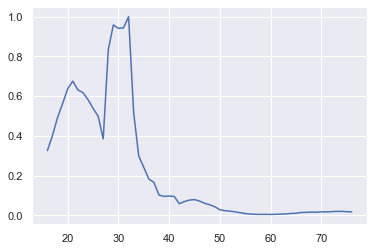

In [35]:
fig, ax = plt.subplots(figsize=(6,4))

tt = t.loc['China - aggregate'][['days_100','dff']].copy().dropna()
#tt = tt.where(tt.dff > 1, 1)
tt['dff'] = tt.dff / tt.dff.max()
ax.plot(tt.days_100, tt.dff) 



NameError: name 'dn' is not defined

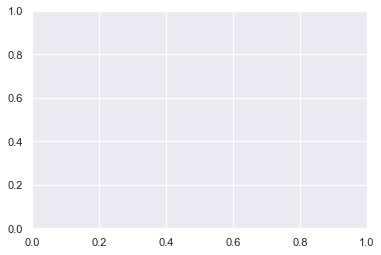

In [36]:
from scipy.stats import norm

country = 'China - aggregate'
country = 'Italy'

X = np.linspace(0,60)

fig, ax = plt.subplots(figsize=(6,4))




ax.plot(tt.days_100,dn) 

n = norm.pdf(X, loc=29, scale=5.5, )
n = n*(dn.max()/n.max()) 
ax.plot(X, n) 



In [1]:
from scipy.optimize import curve_fit
from functools import partial

t = cgt0[cgt0.location == 'Italy'].sort_values(['location','date']).set_index('location').copy()
t['dff'] = t.confirmed.rolling(5).mean().diff()
t['dff'] = t.dff / t.dff.max()
t = t.dropna(subset=['dff'])
dn =  np.exp(t.dff)-1

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(t.days_100,dn) # Blue

dist_max = norm.pdf(mu, loc=mu, scale=std) # For calsing the trial PDFS in the fit unction
data_max = dn.max()

def func(x, mu, std):
    return (norm.pdf(x, loc=mu, scale=std)/dist_max * data_max)  
  
mu = 29
std = 5.5

X = np.linspace(0,t.days_100.max())
Y = func(X,  mu, std)

popt, pcov = curve_fit(func, t.days_100,dn, p0=(mu,std)) 
print(popt)

ax.plot(t.days_100, func(t.days_100, *popt) )


NameError: name 'cgt0' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

tt = t.loc['China - aggregate'][['days_100','dff']].copy().dropna()
#tt = tt.where(tt.dff > 1, 1)
tt['dff'] = tt.dff  / tt.dff.max()
ax.plot(tt.days_100, tt.dff) 

pred = np.exp(func(tt.days_100, *popt))
pred = pred/pred.max()
ax.plot(tt.days_100, pred) 

In [37]:
import metapack as mp
pkg = mp.open_package('http://library.metatab.org/sandiegodata.org-covid19-1.2.14.zip')


sd_covid_cases_df = pkg.resource('sd_covid_cases').dataframe()

In [38]:
sd_covid_cases_df

,date,cases,cases_male,cases_female,hospitalized,intensive_care,deaths,notes
0,2020-03-12,8,NaN,NaN,NaN,NaN,NaN,Cases include confirmed and presumptive
1,2020-03-13,10,NaN,NaN,NaN,NaN,NaN,Cases include confirmed and presumptive
2,2020-03-14,20,NaN,NaN,NaN,NaN,NaN,"Record was missing, so cases value interpolate..."
3,2020-03-15,39,19.0,20.0,12.0,NaN,0.0,NaN
4,2020-03-16,55,35.0,20.0,10.0,NaN,0.0,NaN
5,2020-03-17,60,39.0,21.0,10.0,NaN,0.0,NaN
6,2020-03-18,80,53.0,27.0,11.0,NaN,0.0,NaN
7,2020-03-19,105,67.0,36.0,13.0,NaN,0.0,NaN
8,2020-03-20,131,85.0,45.0,27.0,NaN,0.0,NaN
9,2020-03-21,159,104.0,54.0,34.0,13.0,0.0,NaN
